In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D

2025-04-19 09:20:15.806304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745029215.818303    8072 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745029215.821867    8072 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-19 09:20:15.835671: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
debug = False

In [2]:
DATA_DIR = 'datasets/cats-dogs'
TRAIN_CAT_DIR = os.path.join(DATA_DIR, 'train/cat')
TRAIN_DOG_DIR = os.path.join(DATA_DIR, 'train/dog')
VAL_CAT_DIR = os.path.join(DATA_DIR, 'val/cat')
VAL_DOG_DIR = os.path.join(DATA_DIR, 'val/dog')
IMG_SIZE = (224, 224)

In [3]:
def load_images_and_labels(image_paths, label):
    images = []
    labels = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
train_cat_paths = [os.path.join(TRAIN_CAT_DIR, f) for f in os.listdir(TRAIN_CAT_DIR) if f.endswith('.jpg')]
train_dog_paths = [os.path.join(TRAIN_DOG_DIR, f) for f in os.listdir(TRAIN_DOG_DIR) if f.endswith('.jpg')]
val_cat_paths = [os.path.join(VAL_CAT_DIR, f) for f in os.listdir(VAL_CAT_DIR) if f.endswith('.jpg')]
val_dog_paths = [os.path.join(VAL_DOG_DIR, f) for f in os.listdir(VAL_DOG_DIR) if f.endswith('.jpg')]

In [5]:
train_cat_imgs, train_cat_labels = load_images_and_labels(train_cat_paths, 0)
train_dog_imgs, train_dog_labels = load_images_and_labels(train_dog_paths, 1)
val_cat_imgs, val_cat_labels = load_images_and_labels(val_cat_paths, 0)
val_dog_imgs, val_dog_labels = load_images_and_labels(val_dog_paths, 1)

In [6]:
X_train = np.concatenate([train_cat_imgs, train_dog_imgs])
y_train = np.concatenate([train_cat_labels, train_dog_labels])
X_val = np.concatenate([val_cat_imgs, val_dog_imgs])
y_val = np.concatenate([val_cat_labels, val_dog_labels])

In [7]:
X_train = X_train / 255.0
X_val = X_val / 255.0

<module 'matplotlib.pyplot' from '/home/igor/miniconda3/envs/tf_env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

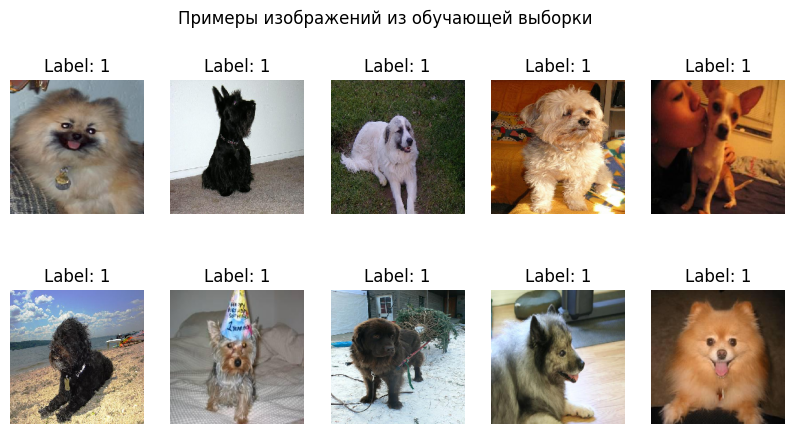

In [8]:
if debug:
    shift = 100
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_train[shift +i])
        plt.title(f'Label: {y_train[shift + i]}')
        plt.axis('off')
    plt.suptitle('Примеры изображений из обучающей выборки')
    plt.show()

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=x)

I0000 00:00:1745029217.875993    8072 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5639 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:2b:00.0, compute capability: 8.6


In [10]:
def extract_features(images, model):
    features = model.predict(images)
    features = features.reshape(features.shape[0], -1)
    return features

In [11]:
X_train_features = extract_features(X_train, model)
X_val_features = extract_features(X_val, model)

I0000 00:00:1745029218.909636    8140 service.cc:148] XLA service 0x7f3a80106710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745029218.909662    8140 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-04-19 09:20:18.918036: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745029218.958337    8140 cuda_dnn.cc:529] Loaded cuDNN version 90300


2/9 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

I0000 00:00:1745029227.273912    8140 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 724ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 857ms/step


In [12]:
X_train_features.shape

(280, 512)

In [13]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_features, y_train)
y_pred = nb_classifier.predict(X_val_features)

In [14]:
f1_score(y_val, y_pred)

0.8444444444444444

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)

In [16]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_features)

In [17]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_train_features)

In [18]:
dbscan = DBSCAN(eps=2.8, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_train_features)

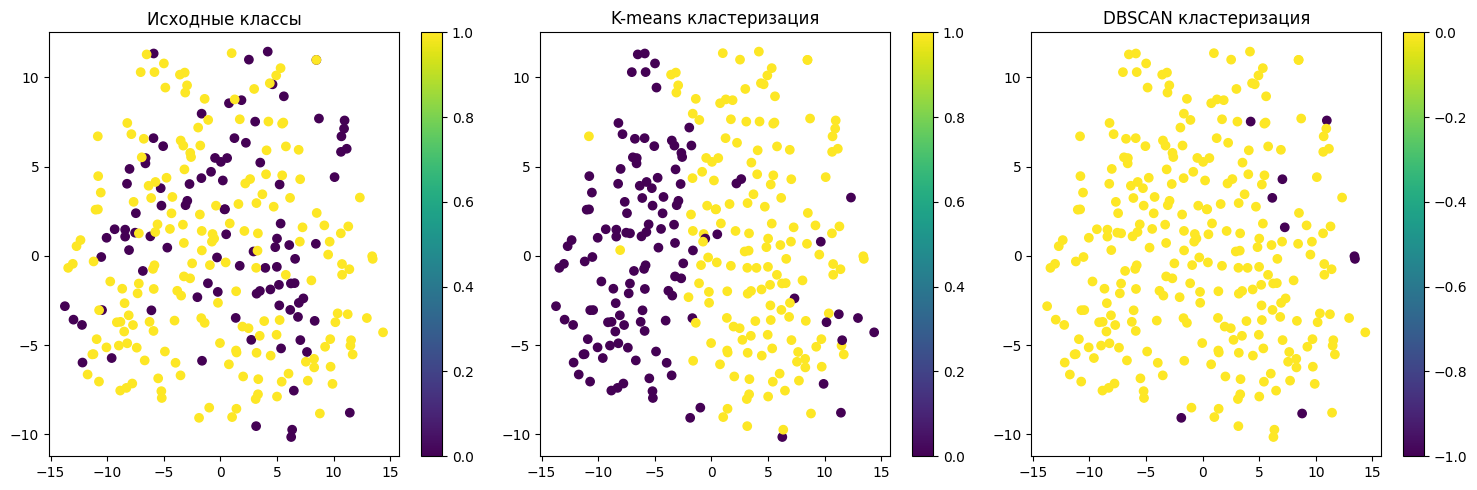

In [19]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis')
plt.title('Исходные классы')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-means кластеризация')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN кластеризация')
plt.colorbar()

plt.tight_layout()
plt.show()

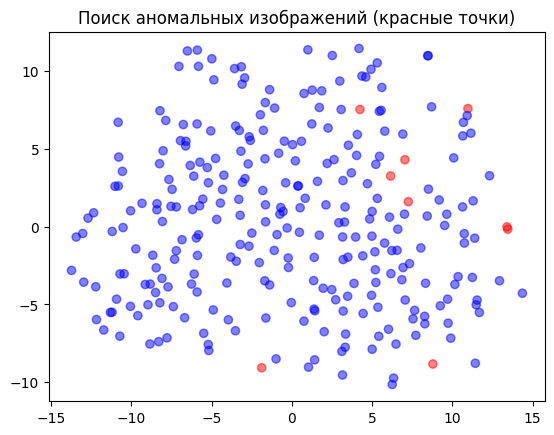

In [20]:
dbscan = DBSCAN(eps=2.8, min_samples=10)
outliers = dbscan.fit_predict(X_train_features)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
            c=np.where(outliers == -1, 'red', 'blue'), alpha=0.5)
plt.title("Поиск аномальных изображений (красные точки)")
plt.show()

Найдено выбросов: 9 из 280 изображений


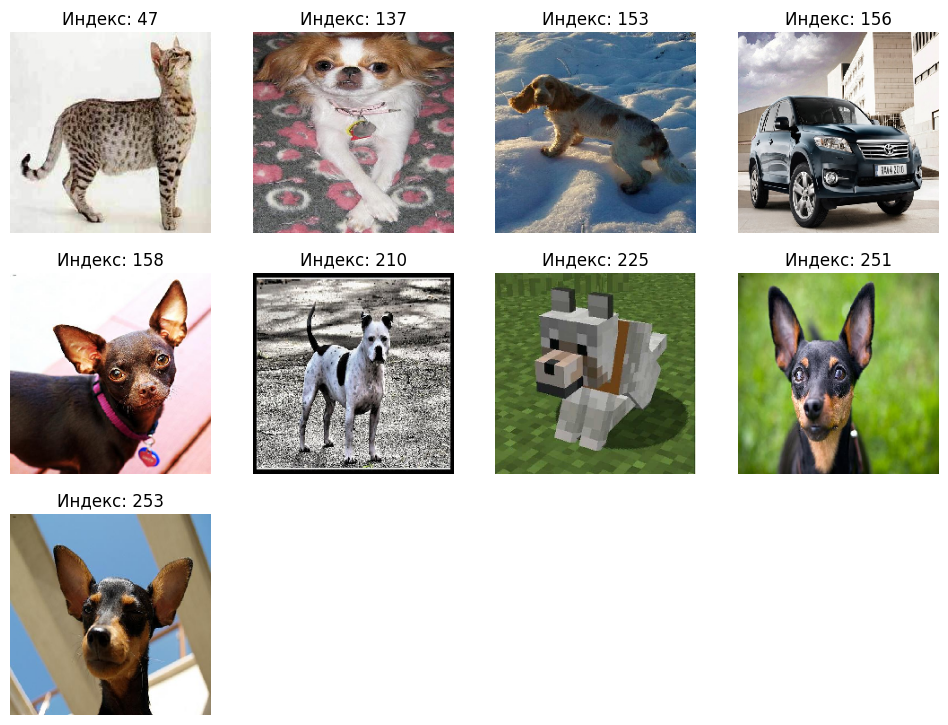

In [21]:
if debug:
    outlier_indices = np.where(outliers == -1)[0]

    print(f"Найдено выбросов: {len(outlier_indices)} из {len(X_train)} изображений")

    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(outlier_indices[:16]):
        plt.subplot(4, 4, i+1)
        plt.imshow(X_train[idx])
        plt.title(f"Индекс: {idx}")
        plt.axis('off')
    plt.show()

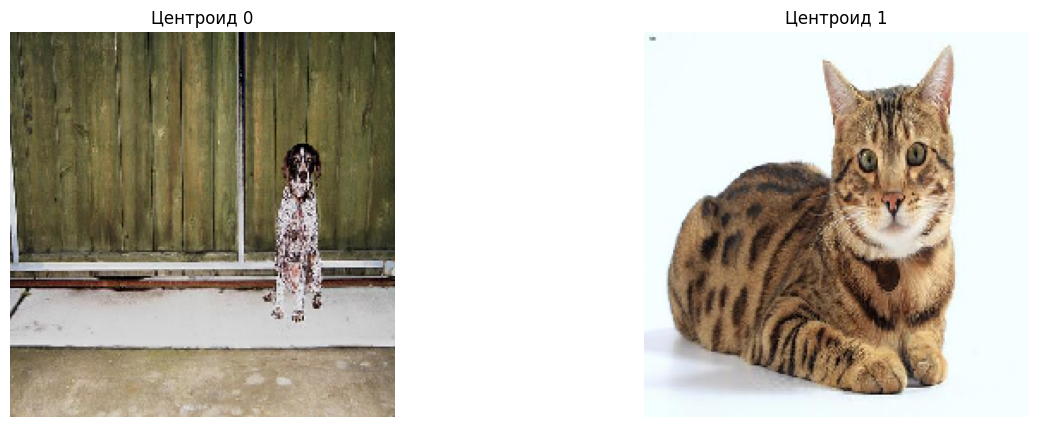

In [22]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_train_scaled)

centroid_features = kmeans.cluster_centers_

from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1).fit(X_train_features)
_, indices = nbrs.kneighbors(centroid_features)

if debug:
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices.flatten()):
        plt.subplot(1, kmeans.n_clusters, i+1)
        plt.imshow(X_train[idx])
        plt.title(f'Центроид {i}')
        plt.axis('off')
    plt.show()